In [1]:
import tensorflow as tf
from tensorflow_probability  import distributions as tfd
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

## Load MNIST dataset

In [2]:
(ds_train, ds_test_), ds_info = tfds.load('mnist', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)


batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)



In [3]:
# return label for testing
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

# Building VAE

In [4]:
class GaussianSampling(Layer):        
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0., stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon

        return samples

class Encoder(Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)
        
        self.features_extract = Sequential([
            Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu'),
            Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu'),
            Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu'),
            Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu'),
            Flatten()])
        
        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
        
    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar

class Decoder(Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)
            
        self.forward = Sequential([
                        Dense(7*7*64, activation='relu'),
                        Reshape((7,7,64)),
                        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
                        UpSampling2D((2,2)),
                        Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
                        UpSampling2D((2,2)),
                        Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid'),
                
        ])

    def call(self, inputs):
        return self.forward(inputs)

    
class VAE(Model):
    def __init__(self, z_dim, name='VAE'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None
        
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)           
        return out
    

# Fit and Train

In [5]:
vae = VAE(z_dim=2)

def vae_kl_loss(y_true, y_pred):
    kl_loss =  - 0.5 * tf.reduce_mean(1 + vae.logvar - tf.square(vae.mean) - tf.exp(vae.logvar))
    return kl_loss    

def vae_rc_loss(y_true, y_pred):
    rc_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return rc_loss

def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 1e-2
    return kl_weight_const*kl_loss + rc_loss

model_path = "./models/vae.h5"
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "vae_rc_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "vae_rc_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [checkpoint, early]

vae.compile(
    loss = [vae_loss],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[vae_kl_loss,vae_rc_loss])

vae.fit(ds_train, validation_data=ds_test,
                epochs = 50, callbacks = callbacks_list)



Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 0.2889 - vae_kl_loss: 0.3904 - vae_rc_loss: 0.2851
Epoch 00001: vae_rc_loss improved from inf to 0.28505, saving model to ./models/vae.h5
235/235 [==============================] - 2s 8ms/step - loss: 0.2889 - vae_kl_loss: 0.3904 - vae_rc_loss: 0.2851 - val_loss: 0.2361 - val_vae_kl_loss: 1.1691 - val_vae_rc_loss: 0.2244
Epoch 2/50
227/235 [===========================>..] - ETA: 0s - loss: 0.2300 - vae_kl_loss: 1.4121 - vae_rc_loss: 0.2159
Epoch 00002: vae_rc_loss improved from 0.28505 to 0.21576, saving model to ./models/vae.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.2299 - vae_kl_loss: 1.4146 - vae_rc_loss: 0.2158 - val_loss: 0.2265 - val_vae_kl_loss: 1.4690 - val_vae_rc_loss: 0.2118
Epoch 3/50
233/235 [============================>.] - ETA: 0s - loss: 0.2251 - vae_kl_loss: 1.5682 - vae_rc_loss: 0.2094
Epoch 00003: vae_rc_loss improved from 0.21576 to 0.20937, saving model to ./models/vae.h

Epoch 22/50
230/235 [============================>.] - ETA: 0s - loss: 0.2137 - vae_kl_loss: 2.0223 - vae_rc_loss: 0.1934
Epoch 00022: vae_rc_loss improved from 0.19390 to 0.19341, saving model to ./models/vae.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.2136 - vae_kl_loss: 2.0224 - vae_rc_loss: 0.1934 - val_loss: 0.2133 - val_vae_kl_loss: 2.0259 - val_vae_rc_loss: 0.1930
Epoch 23/50
231/235 [============================>.] - ETA: 0s - loss: 0.2135 - vae_kl_loss: 2.0347 - vae_rc_loss: 0.1932
Epoch 00023: vae_rc_loss improved from 0.19341 to 0.19321, saving model to ./models/vae.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.2136 - vae_kl_loss: 2.0352 - vae_rc_loss: 0.1932 - val_loss: 0.2131 - val_vae_kl_loss: 2.0455 - val_vae_rc_loss: 0.1927
Epoch 24/50
231/235 [============================>.] - ETA: 0s - loss: 0.2133 - vae_kl_loss: 2.0492 - vae_rc_loss: 0.1928
Epoch 00024: vae_rc_loss improved from 0.19321 to 0.19282, saving model to ./model

Epoch 43/50
231/235 [============================>.] - ETA: 0s - loss: 0.2111 - vae_kl_loss: 2.1334 - vae_rc_loss: 0.1898
Epoch 00043: vae_rc_loss improved from 0.18995 to 0.18980, saving model to ./models/vae.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.2111 - vae_kl_loss: 2.1336 - vae_rc_loss: 0.1898 - val_loss: 0.2110 - val_vae_kl_loss: 2.1386 - val_vae_rc_loss: 0.1896
Epoch 44/50
231/235 [============================>.] - ETA: 0s - loss: 0.2110 - vae_kl_loss: 2.1390 - vae_rc_loss: 0.1896
Epoch 00044: vae_rc_loss improved from 0.18980 to 0.18965, saving model to ./models/vae.h5
235/235 [==============================] - 1s 6ms/step - loss: 0.2110 - vae_kl_loss: 2.1387 - vae_rc_loss: 0.1896 - val_loss: 0.2110 - val_vae_kl_loss: 2.1493 - val_vae_rc_loss: 0.1895
Epoch 45/50
231/235 [============================>.] - ETA: 0s - loss: 0.2111 - vae_kl_loss: 2.1451 - vae_rc_loss: 0.1896
Epoch 00045: vae_rc_loss improved from 0.18965 to 0.18963, saving model to ./model

# Look at latent space distribution

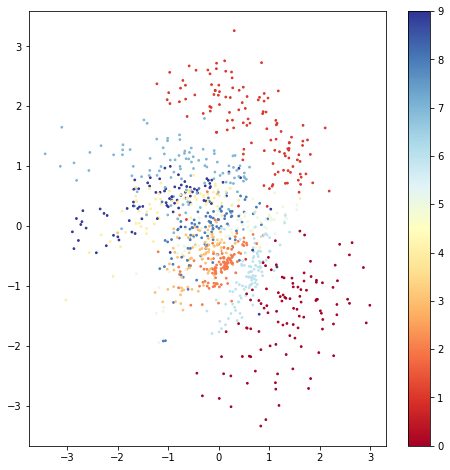

In [13]:
vae.load_weights(model_path)
images, labels = next(iter(ds_test_label))
outputs, z_means, z_logvar = vae.encoder(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()

# Generate Samples

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = np.array([[z1, z2]], dtype=np.float32)
    images = vae.decoder(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:,0], cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

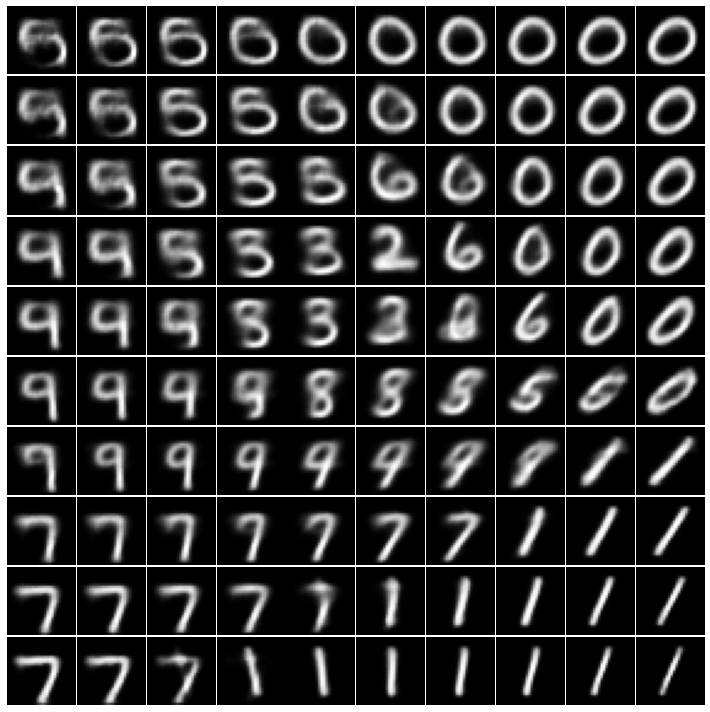

In [9]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-2.5,2.5,0.5) for z1 in np.arange(-2.5,2.5,0.5)], dtype=np.float32)
images = vae.decoder(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show() 